In [1]:
### Import block

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import pandas as pd
import gdown
import zipfile
import os
import seaborn as sns

In [3]:
# sub import

In [4]:
from tensorflow.python.keras.utils.version_utils import callbacks
from torchvision import datasets, transforms
from keras.callbacks import ModelCheckpoint
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.src.metrics.accuracy_metrics import accuracy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
### Loading data into the workspace

In [6]:
file_id = "1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY"
url = f"https://drive.google.com/uc?id={file_id}"
output = "Teeth Dataset.zip"
gdown.download(url, output, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=e2e68c43-f55e-4c80-b9aa-fec03ebbeed1
To: C:\Users\NV_User\Code\Teeth Dataset.zip
100%|█████████████████████████████████████████████████████████████████████████████| 49.1M/49.1M [00:33<00:00, 1.46MB/s]


'Teeth Dataset.zip'

In [7]:
# unzip

In [8]:
with zipfile.ZipFile(output) as zip_ref:
    zip_ref.extractall("Teeth_Dataset")


In [9]:
# loading details

In [10]:
data_directory = "Teeth_Dataset/Teeth_Dataset"
diseases = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
img_size = (256,256)
batch_size = 32

In [11]:
# normalization

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
# training data

In [14]:
dataset_training = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, "Training"),
    image_size=img_size,
    batch_size=batch_size,
    class_names=diseases
)
dataset_training = dataset_training.map(lambda x, y: (normalization_layer(x), y))

Found 3087 files belonging to 7 classes.


In [15]:
# validation data

In [16]:
dataset_validation = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, "Validation"),
    image_size=img_size,
    batch_size=batch_size,
    class_names=diseases
)
dataset_validation = dataset_validation.map(lambda x, y: (normalization_layer(x), y))

Found 1028 files belonging to 7 classes.


In [17]:
# testing data

In [18]:

dataset_testing = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, "Testing"),
    image_size=img_size,
    batch_size=batch_size,
    class_names=diseases
)
dataset_testing = dataset_testing.map(lambda x, y: (normalization_layer(x), y))

Found 1028 files belonging to 7 classes.


In [19]:
#data augmentation

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")


In [21]:
### Building the model

In [22]:
# MobileNetV2
def build_mobilenetV2_classifier(num_classes=7):
    base_model = MobileNetV2(include_top=False,input_shape=(256,256,3))
    base_model.trainable = False
    model = models.Sequential([
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        #adding batch normalization
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    #compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    #unfreezing layers for finetuning
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )
    return model

In [23]:
# training the model

In [24]:
teeth_classifier = build_mobilenetV2_classifier(num_classes=7)

C:\Users\NV_User\AppData\Local\Temp\ipykernel_14352\3072252310.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False,input_shape=(256,256,3))


In [25]:
# model preview 

In [26]:
teeth_classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,855,104 (7.08 MB)

 Non-trainable params: 402,880 (1.54 MB)

In [27]:
#callback for saving best

In [28]:
checkpoint = ModelCheckpoint(
    "best_teeth_model.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [29]:
# history

In [30]:
history = teeth_classifier.fit(dataset_training,
                           validation_data=dataset_validation,
                           epochs=10, callbacks=[checkpoint])

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.4645 - loss: 1.6326
Epoch 1: val_accuracy improved from None to 0.15759, saving model to best_teeth_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 70s 651ms/step - accuracy: 0.6051 - loss: 1.1772 - val_accuracy: 0.1576 - val_loss: 4.6502
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.8324 - loss: 0.5117
Epoch 2: val_accuracy improved from 0.15759 to 0.26751, saving model to best_teeth_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 652ms/step - accuracy: 0.8620 - loss: 0.4320 - val_accuracy: 0.2675 - val_loss: 3.7161
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9235 - loss: 0.2708
Epoch 3: val_accuracy improved from 0.26751 to 0.44553, saving model to best_teeth_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 644ms/step - accuracy: 0.9329 - loss: 0.2417 - val_accuracy: 0.4455 - val_loss: 1.7418
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9594 - loss: 0.1488
Epoch 4: val_accurac

In [31]:
# visualization function

In [32]:
def visualization(accuracy, validation_accuracy, loss, validation_loss,epochs):
    plt.figure(figsize=(10,5))
    plt.plot(epochs, accuracy, "r", label="Training Accuracy")
    plt.plot(epochs, validation_accuracy, "g", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc=0)
    # new figure
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, "b", label="Training Loss")
    plt.plot(epochs, validation_loss, "y", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc=0)
    plt.show()

In [33]:
#history data acquisition

In [34]:
teeth_classifier_history = history.history
accuracy = teeth_classifier_history["accuracy"]
validation_accuracy = teeth_classifier_history["val_accuracy"]
loss = teeth_classifier_history["loss"]
validation_loss = teeth_classifier_history["val_loss"]
epochs = history.epoch

In [35]:
#visualization execution

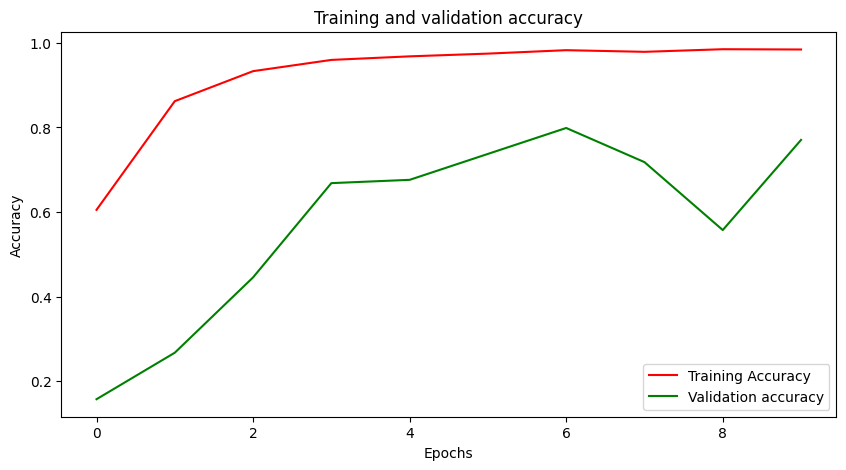

<Figure size 640x480 with 0 Axes>

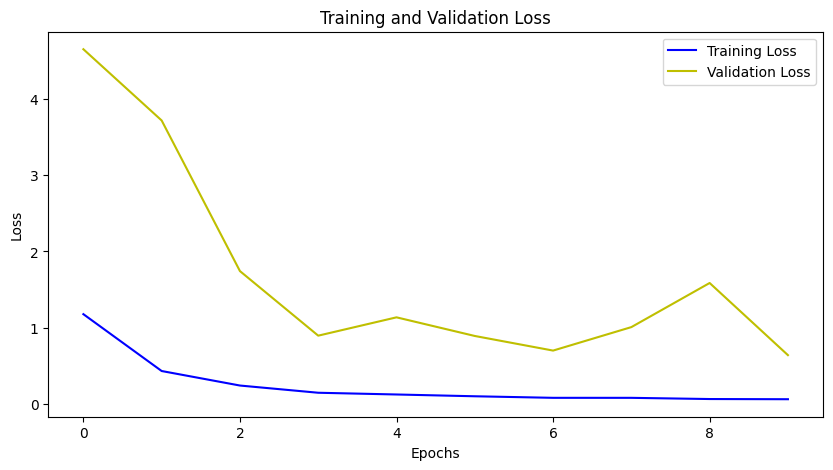

In [36]:
visualization(accuracy,validation_accuracy, loss, validation_loss, epochs)

In [37]:
#Perparing for more data insights

In [38]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in dataset_testing:
    preds = teeth_classifier.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [39]:
#Confusion Matrix

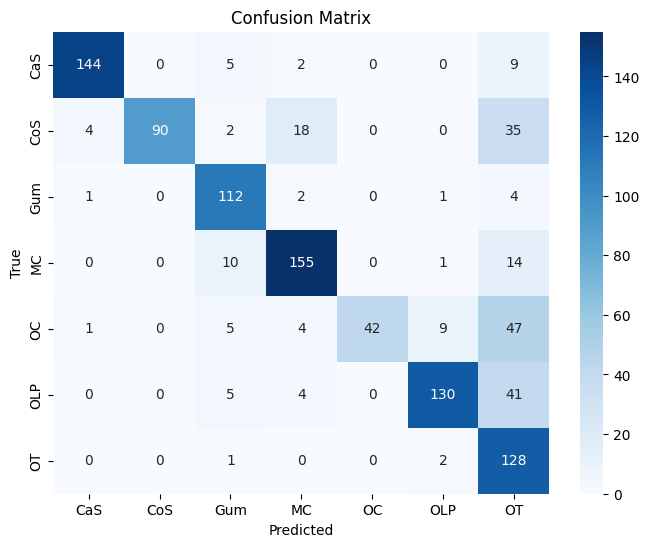

In [40]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=diseases,
            yticklabels=diseases)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [41]:
#Classification Report

In [42]:
report = classification_report(y_true, y_pred, target_names=diseases)
print(report)


              precision    recall  f1-score   support

         CaS       0.96      0.90      0.93       160
         CoS       1.00      0.60      0.75       149
         Gum       0.80      0.93      0.86       120
          MC       0.84      0.86      0.85       180
          OC       1.00      0.39      0.56       108
         OLP       0.91      0.72      0.80       180
          OT       0.46      0.98      0.63       131

    accuracy                           0.78      1028
   macro avg       0.85      0.77      0.77      1028
weighted avg       0.86      0.78      0.78      1028

